In [41]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_temporales as st
from src import soporte_sarima as ss
from src import soporte_funciones_BBDD as sfbd
from src import soporte_variables_defunciones as svd

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Query para traer datos agrupados

In [42]:
df_defunciones = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svd.query_EDA_1)

In [43]:
df_defunciones.head()

,fecha,casos_defunciones
0,2007-01-01,146
1,2007-02-01,136
2,2007-03-01,156
3,2007-04-01,147
4,2007-05-01,117


# Defunciones

In [44]:
df_copia = df_defunciones.copy()
df_copia['fecha'] = pd.to_datetime(df_copia['fecha'])
df_copia["Month"] = df_copia["fecha"].dt.month_name()
df_copia["Year"] = df_copia["fecha"].dt.year
df_copia.head()

,fecha,casos_defunciones,Month,Year
0,2007-01-01,146,January,2007
1,2007-02-01,136,February,2007
2,2007-03-01,156,March,2007
3,2007-04-01,147,April,2007
4,2007-05-01,117,May,2007


In [45]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_copia, temporal_column="fecha", value_column="casos_defunciones")

analisis_st.exploracion_datos()

El número de filas es 204 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
casos_defunciones,204,154,25,77,137,153,169,208
Year,204,2015,5,2007,2011,2015,2019,2023


In [46]:
analisis_st.comprobar_serie_continua()

La serie temporal es continua para la frecuencia 'M', no faltan periodos.


In [47]:
analisis_st.graficar_serie()

In [48]:
analisis_st.graficar_media_movil(window=12)

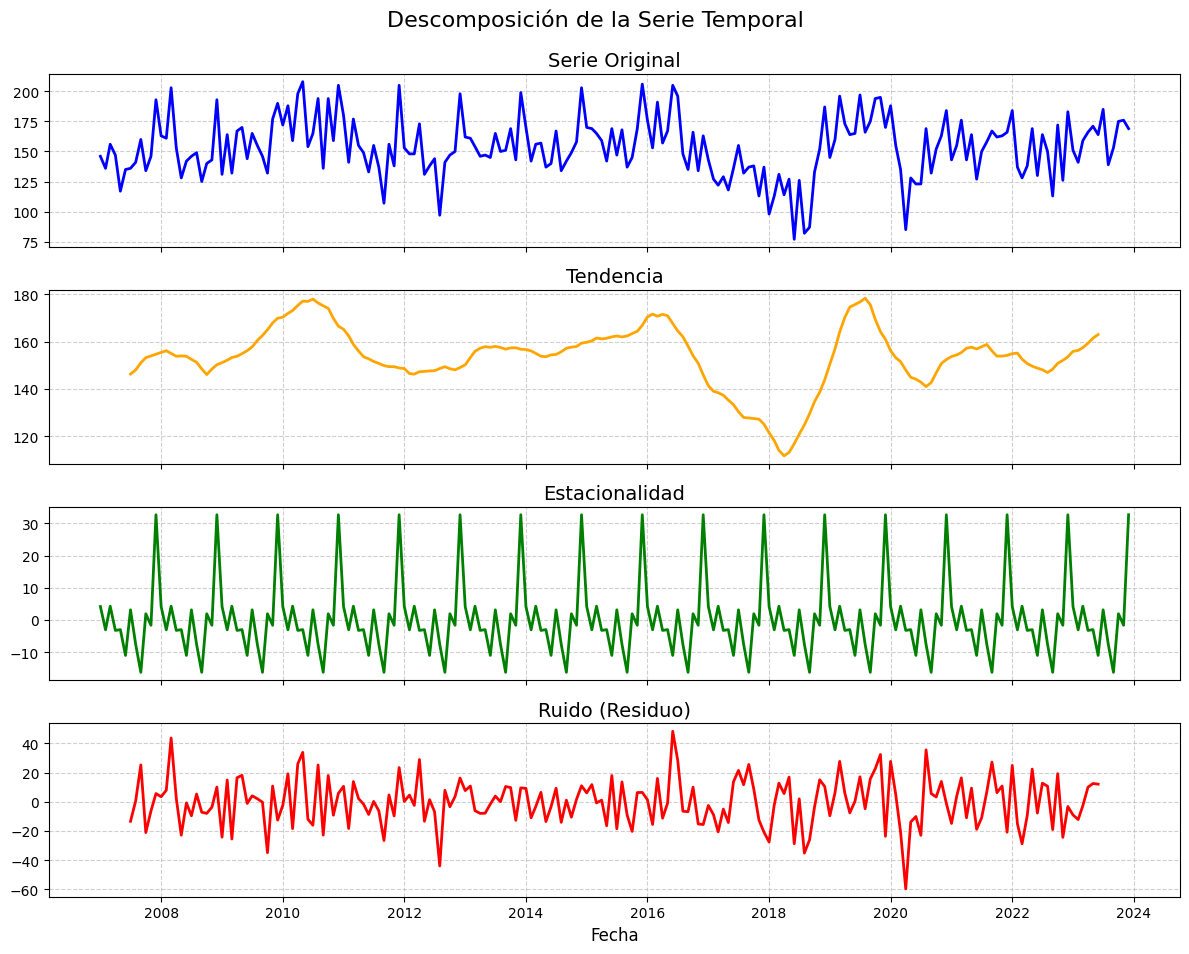

In [49]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

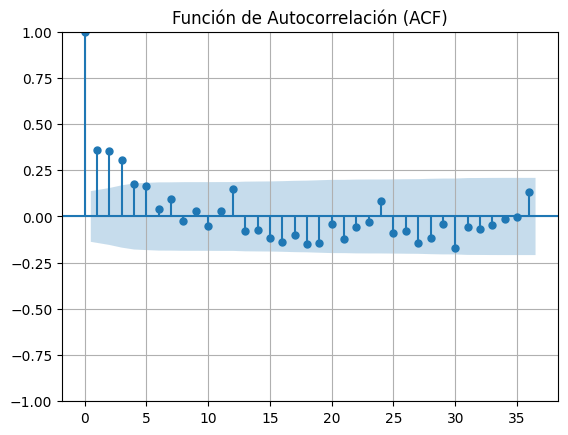

<Figure size 1200x1000 with 0 Axes>

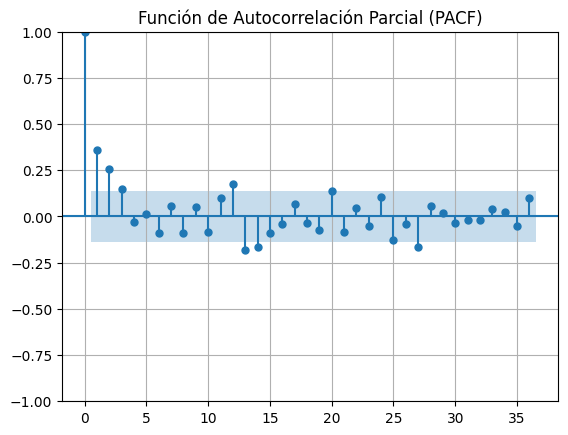

In [50]:
analisis_st.graficar_acf_pacf(lags=36)

In [51]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.6734269015355294
p-value: 0.004502839670564938
Valores Críticos:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Rechazamos la hipótesis nula. La serie es estacionaria.


In [52]:
df_defunciones.set_index('fecha', inplace=True)

In [53]:
train_size = int(0.7 * len(df_defunciones))
y_train, y_test = df_defunciones[:train_size], df_defunciones[train_size:]

In [54]:
sarima = ss.SARIMAModel()

# Definir los rangos para los parámetros
p_range = range(4)
q_range = range(5)
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(0, 0, (0, 0, 0, 12)),
 (0, 0, (0, 0, 1, 12)),
 (0, 0, (0, 1, 0, 12)),
 (0, 0, (0, 1, 1, 12)),
 (0, 0, (1, 0, 0, 12))]

100%|██████████| 160/160 [01:58<00:00,  1.35it/s]


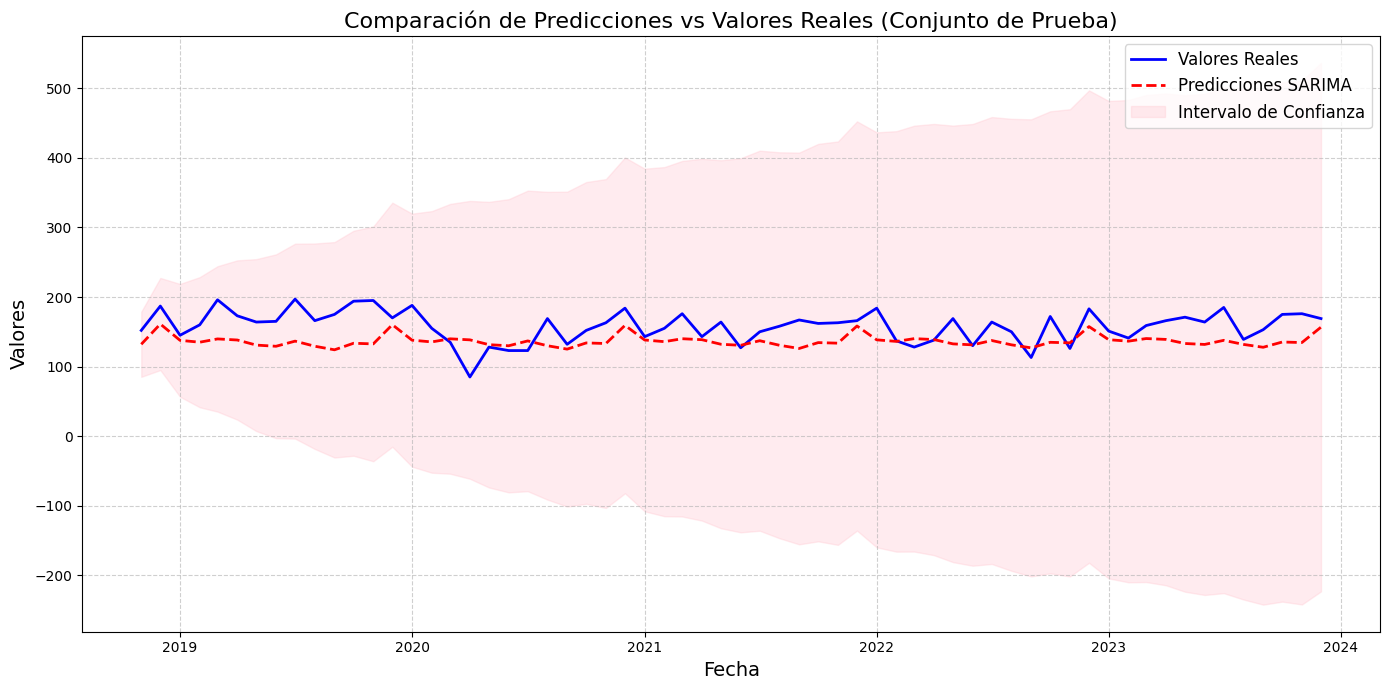

In [55]:
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df_defunciones), variable="casos_defunciones")

In [56]:
# Ordenar resultados por RMSE
results_df = results_df.sort_values(by="RMSE", ascending=True)
results_df.head()

,p,q,seasonal_order,RMSE
5,0,0,"(1, 0, 1, 12)",30
0,0,0,"(0, 0, 0, 12)",33
7,0,0,"(1, 1, 1, 12)",34
3,0,0,"(0, 1, 1, 12)",34
1,0,0,"(0, 0, 1, 12)",34


In [57]:
modelo_sarima= SARIMAX(df_defunciones, 
                    order= (3,1,3),                    #Se pone la p, la d y la q
                    seasonal_order= (1,0,1,12)).fit()   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df_defunciones), end=len(df_defunciones)+24)   #pongo el más 30 porque son los que quiero predecir

pred_y= pred_y.astype(int)
datos_predichos=pd.DataFrame(pred_y)

In [58]:
y_test.index = pd.to_datetime(y_test.index)
datos_predichos.index = pd.to_datetime(datos_predichos.index)

Text(0.5, 1.0, 'Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

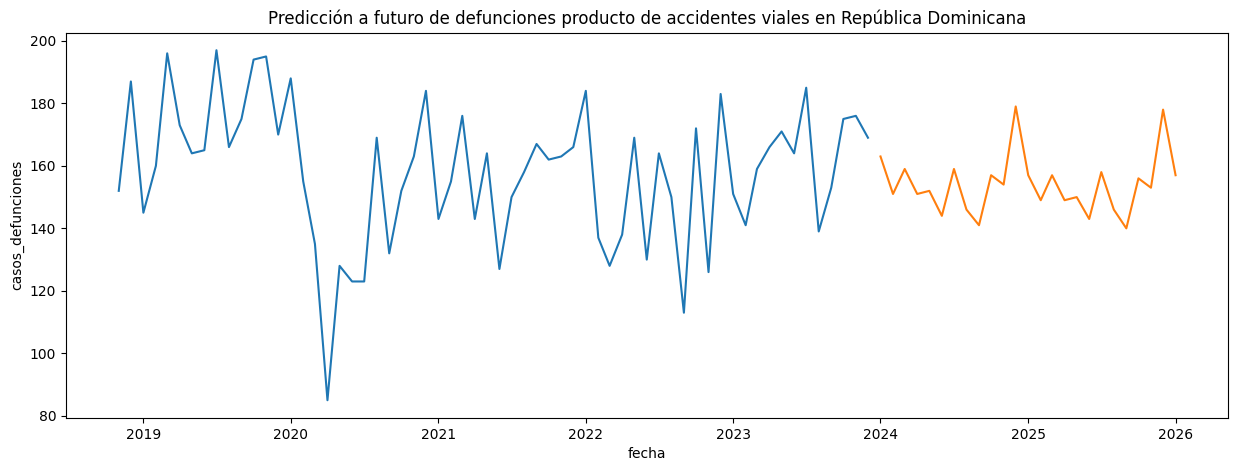

In [59]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='casos_defunciones', data=y_test)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

In [60]:
df_defunciones.reset_index(inplace=True)

## Modelo usando Prophet

In [61]:
df_defunciones.columns = ['ds', 'y']

In [62]:
m = Prophet()
m.fit(df_defunciones)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=25, freq='M') 
m.predict(df_defunciones)

16:58:55 - cmdstanpy - INFO - Chain [1] start processing
16:58:56 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-01,156,132,189,156,156,4,4,4,4,4,4,0,0,0,159
1,2007-02-01,156,122,179,156,156,-4,-4,-4,-4,-4,-4,0,0,0,152
2,2007-03-01,155,134,188,155,155,4,4,4,4,4,4,0,0,0,160
3,2007-04-01,155,124,182,155,155,-2,-2,-2,-2,-2,-2,0,0,0,153
4,2007-05-01,155,122,179,155,155,-4,-4,-4,-4,-4,-4,0,0,0,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2023-08-01,152,114,172,152,152,-9,-9,-9,-9,-9,-9,0,0,0,143
200,2023-09-01,152,109,163,152,152,-16,-16,-16,-16,-16,-16,0,0,0,135
201,2023-10-01,151,126,181,151,151,3,3,3,3,3,3,0,0,0,155
202,2023-11-01,151,126,180,151,151,0,0,0,0,0,0,0,0,0,152


In [63]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
217,2025-01-31,147,118,174
218,2025-02-28,155,128,185
219,2025-03-31,150,124,178
220,2025-04-30,148,119,177
221,2025-05-31,139,111,167
222,2025-06-30,156,127,184
223,2025-07-31,142,115,170
224,2025-08-31,134,110,164
225,2025-09-30,154,126,182
226,2025-10-31,152,122,180


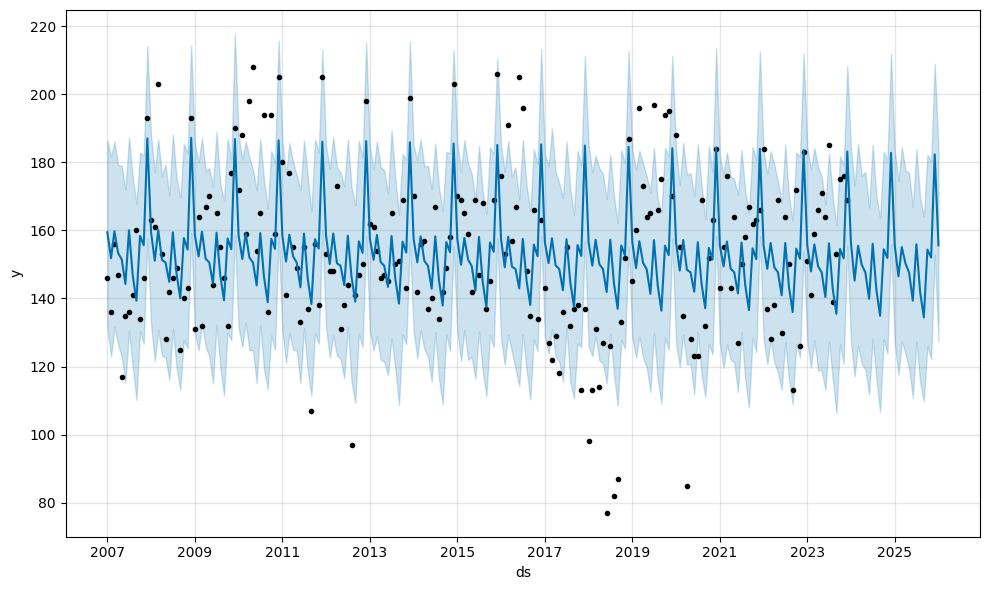

In [64]:
fig1 = m.plot(forecast)

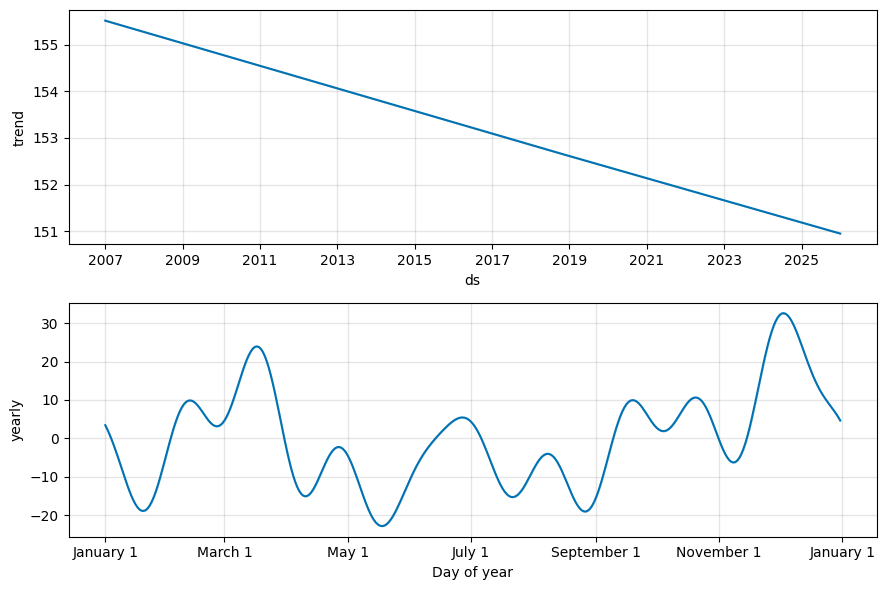

In [65]:
fig2 = m.plot_components(forecast)

In [66]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [67]:
plot_components_plotly(m, forecast)